In [1]:
"""
Sources:

2. https://towardsdatascience.com/forecasting-stock-prices-using-xgboost-a-detailed-walk-through-7817c1ff536a

https://www.bloomberg.com/graphics/world-economic-indicators-dashboard/?leadSource=uverify%20wall

- Hierarchical TS: https://www.kaggle.com/code/jagangupta/time-series-basics-exploring-traditional-ts

-Read this after workout: https://www.kaggle.com/code/gargaar/time-series-with-python


Credit: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error
from dateutil.relativedelta import relativedelta
from dateutil import relativedelta
from sklearn.model_selection import TimeSeriesSplit
import datetime


In [2]:
def first_day_of_month(date):
    """
    Sets all dates to first day of the month
    
    :param date: date object
    
    :return: date object with day replaced with one
    """
    year = date.year
    month = date.month
    return pd.datetime(year, month, 1)

def add_lags(df, num_lags, feature_lag_lst):
    """
    
    :param df: data frame to add lags to
    :param num_lags: # of lags
    :param feature_lag_lst: features to add lags to
    
    :return df, lag_lst: data frame with lags and list of lags
    """
    df = df.copy()
    lag_lst = []
    if num_lags:
        for feature in feature_lag_lst:
            target_map = df[feature].to_dict()
            for lag in range(1, num_lags):
                df[f'{feature}_lag_{lag}'] = (df.index - pd.DateOffset(months=lag)).map(target_map)
                lag_lst.append(f'{feature}_lag_{lag}')
        
    # df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map) # 364
    # df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map) # 728
    # df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map) # 1092
    return df, lag_lst

def generate_lagged_features_lst(lagged_attr, num_lags):
    """
    Generates a lagged feature list
    TODO: lag_lst from above can probably replace this
    
    :param lagged_attr: attributes to add the "lag_#" tag
    :param num_lags: number of lags
    
    :return features: list of features with the "lag_#" tag
    """
    
    features = []
    for attr in lagged_attr:
        for i in range(1,num_lags):
            features.append(f"{attr}_lag_{i}")
    return features

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    #df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    #df['dayofyear'] = df.index.dayofyear
    #df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    return df

In [3]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

In [4]:
def preprocess(df):
    df = df.copy()
    df.columns = [signal.lower().replace(" ", "_") for signal in df.columns] # upper to lower and replace space with underscores
    df['date'] = pd.to_datetime(df['date']) # To date-time object conversion
    df = df.resample('M', on='date').mean() # Up-sample
    df.index = df.index.map(first_day_of_month) # Set index
    return df

In [5]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    # Create Lags
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['close'].shift(-i)
        i = i + 1
    
    # Create Steps
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['close'].shift(-output_length-j)
        j = j + 1
        
    # Drop all NaNs
    df = df.dropna(axis=0)
    
    return df

In [6]:
def create_lags(num_lags: int, feature_lst: list, data: pd.DataFrame, dropnan: bool) -> pd.DataFrame:
    """
    Create lagged features/target values from previous periods. At the moment, this function
    does this on a monthly level
    """
    df = data.copy()
    
    # Create Lags
    i = 1
    while i < num_lags:
        for feature in feature_lst:
            lagged_feature = f"x_lag_{feature}_{i}"
            df[lagged_feature] = df[f"{feature}"].shift(i) # Added lagged feature
        i = i + 1
    
    if dropnan: 
        df = df.dropna(axis = 0)
        
    return df

In [7]:
def create_steps(num_steps: int, target_lst: list, data: pd.DataFrame, dropnan: bool) -> pd.DataFrame:
    """
    Create steps into the future that you're trying to forecast
    """
    df = data.copy()
    
    # Create Steps
    i = 0
    while i < num_steps:
        for target in target_lst:
            step = f"y_step_{target}_{i}"
            df[step] = df[f"{target}"].shift(-num_steps-i) # Added Steps
        i = i + 1
    
    if dropnan: 
        df = df.dropna(axis = 0)
        
    return df

In [41]:
def cat_val_in_arr(data: list, categories: list) -> dict: 
    """
    Function that categorizes data in a given array based on number of total categories
    and stores resultant data in a dictionary of categorized arrays
    
    ex: 
        data = [1, 3, 5, 6, 4, 8, 3, 9, 11, ...]
    
                 idx |1. 2. 3. ...|
        categories = [a, b, c, ...]
        
        - There are three total categories. Every 3rd value in array starting
          and including zeroeth index value will be extracted
    
        - data will be split into as follow:
        - a_arr = [1, 6, 3]
        - b_arr = [3, 4, 9]
        - c_arr = [5, 8, 11]
    
    :param dataay: array to split
    :param categories: distinct array to split main data
    
    :return res: final output with values categorized and stored in a dictonary of n*category arrays
    """
    
    len_data = len(data)
    len_cat = len(categories)
    res = {} # store results in here
    
    cat_idx = 0 # init category index
    while cat_idx < len_cat: # Iterate through all categories
        # Assign category index to data index. 
        # This is the starting index for the data extraction step
        data_idx = cat_idx
        res[categories[cat_idx]] = [] # init dict to store data sorted into categories
        
        # Extract and sort data into its' category 
        # This is where we are extracting every nth data starting from index derived in above step
        while data_idx < len_data: 
            res[categories[cat_idx]].append(data[data_idx]) # Store value in categorical array
            data_idx += len_cat # Increment to next value
            
        cat_idx += 1 # Increment to next category 
            
    return res

In [8]:
qqq_df = pd.read_csv("QQQ.csv")
nvda_df = pd.read_csv("NVDA.csv")
spy_df = pd.read_csv("SPY.csv")
vti_df = pd.read_csv("VTI.csv")


qqq_df = preprocess(qqq_df)
nvda_df = preprocess(nvda_df)
spy_df = preprocess(spy_df)
vti_df = preprocess(vti_df)


df = nvda_df.copy()
df["qqq_close"] = qqq_df["close"]
df["spy_close"] = spy_df["close"]
df["vti_close"] = vti_df["close"]

df.head(20)

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


,open,high,low,close,adj_close,volume,qqq_close,spy_close,vti_close
date,,,,,,,,,
2000-01-01,0.897461,0.916211,0.857357,0.886068,0.813191,2.470728e+07,90.579688,142.762500,NaN
2000-02-01,1.080990,1.127214,1.044401,1.101628,1.011021,4.580424e+07,100.298438,139.070312,NaN
2000-03-01,1.873825,2.044837,1.740815,1.870429,1.716590,7.631374e+07,111.057405,144.610734,NaN
2000-04-01,1.753478,1.875754,1.628906,1.746214,1.602592,3.411436e+07,93.633224,146.337171,NaN
2000-05-01,1.991211,2.098603,1.904652,2.005001,1.840094,3.952538e+07,85.187500,142.016335,NaN
2000-06-01,2.867572,3.010949,2.726281,2.868800,2.632848,6.032411e+07,93.596591,146.522727,NaN
2000-07-01,2.668750,2.781120,2.548568,2.654167,2.435868,3.640176e+07,95.652344,147.502344,NaN
2000-08-01,2.901948,3.019078,2.836730,2.947605,2.705171,2.643151e+07,94.259511,148.963315,NaN
2000-09-01,3.057422,3.178386,2.967318,3.081185,2.827764,2.934288e+07,93.076562,146.927344,NaN


In [51]:
"""
Training on All Data
"""
TARGET = ["close", "volume"]
FEATURES = ["close", "volume"]
STEPS = 18
LAGS = 13

forecast_dict = {}

df = df[FEATURES]
lagged_df = create_lags(LAGS, TARGET, df, True)
stepped_df = create_steps(STEPS, TARGET, df, True)
# Drop target from one data frame and combine since both data frames contain 
seq_df = pd.merge(lagged_df.drop(columns = TARGET), stepped_df, left_index=True, right_index=True)

X_cols = [col for col in seq_df.columns if col.startswith('x')]

for idx, val in enumerate(TARGET): # Add in present output
    X_cols.insert(0, TARGET[idx])
    forecast_dict[val] = []
    
y_cols = [col for col in seq_df.columns if col.startswith('y')]
X_train = seq_df[X_cols].values
y_train = seq_df[y_cols].values


"""
Prepare Data frame to hold forecast results
"""
forecast_date_lst = pd.date_range(datetime.date.today(), periods=STEPS, freq = 'M')
forecast_df = pd.DataFrame()
forecast_df['index'] = forecast_date_lst.values
forecast_df = forecast_df.set_index('index')

"""
Prepare inputs to feed into forecast
"""
forecast_inputs = create_lags(LAGS, TARGET, df, False)[X_cols][-1:] # December 1, 2022 features to input for forecasting


In [52]:
"""
Model Training w/ Decision Tree Regressor
"""
from sklearn.tree import DecisionTreeRegressor
short_name = "dt"
dt_seq = DecisionTreeRegressor(random_state=42)
dt_seq.fit(X_train, y_train)
#dt_seq_preds = dt_seq.predict(X_test)

"""
Run Forecasts
"""

dt_seq_res = dt_seq.predict(forecast_inputs)

"""
Store Results
"""

# Store results in series
#forecast_series = pd.Series(data = dt_seq_res[0], index = forecast_df.index) # *** maybe don't need this

"""
If multi-variate forecast, take individual results out of single numpy array
and store forecast results in lists dedicated to the target. 
"""
forecast_dict = cat_val_in_arr(dt_seq_res[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


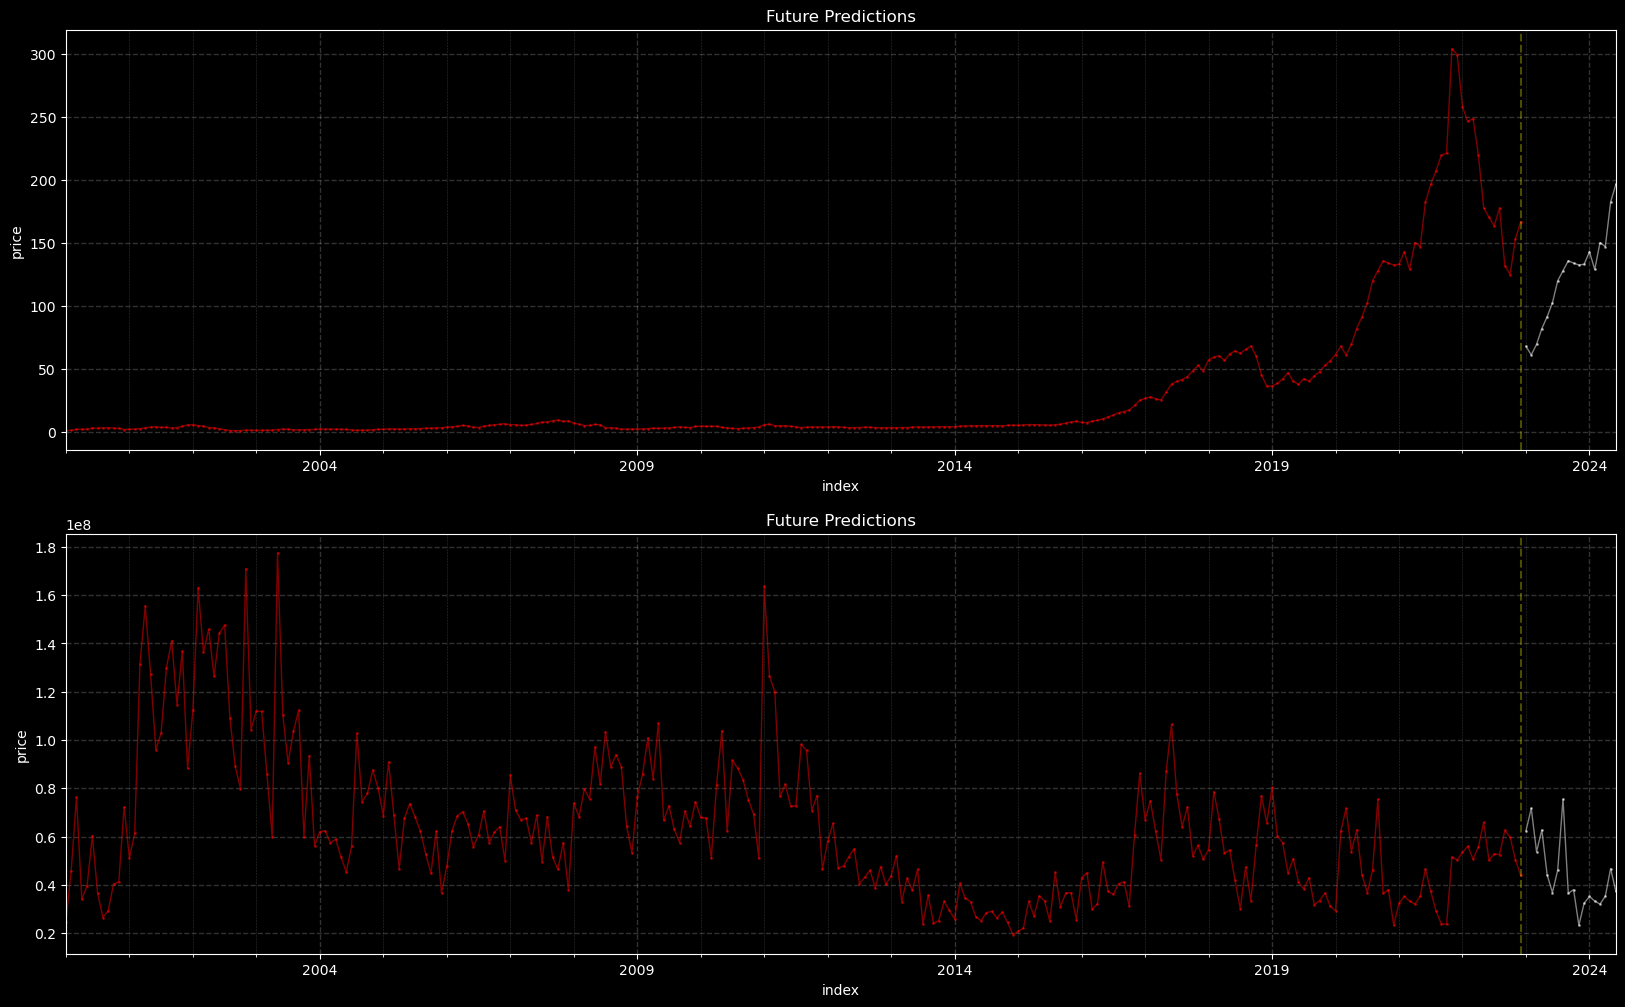

In [77]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

In [101]:
"""
Model Training w/ Gradient Boosted Regressor
"""

from sklearn.multioutput import RegressorChain
from sklearn.ensemble import GradientBoostingRegressor

short_name = "gbr"
gbr_seq = GradientBoostingRegressor(random_state=42)
chained_gbr = RegressorChain(gbr_seq)
chained_gbr.fit(X_train, y_train)


"""
Run Forecasts
"""
gbr_seq_preds = chained_gbr.predict(forecast_inputs) # X_test

"""
Store Results
"""

forecast_dict = cat_val_in_arr(gbr_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RegressorChain was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


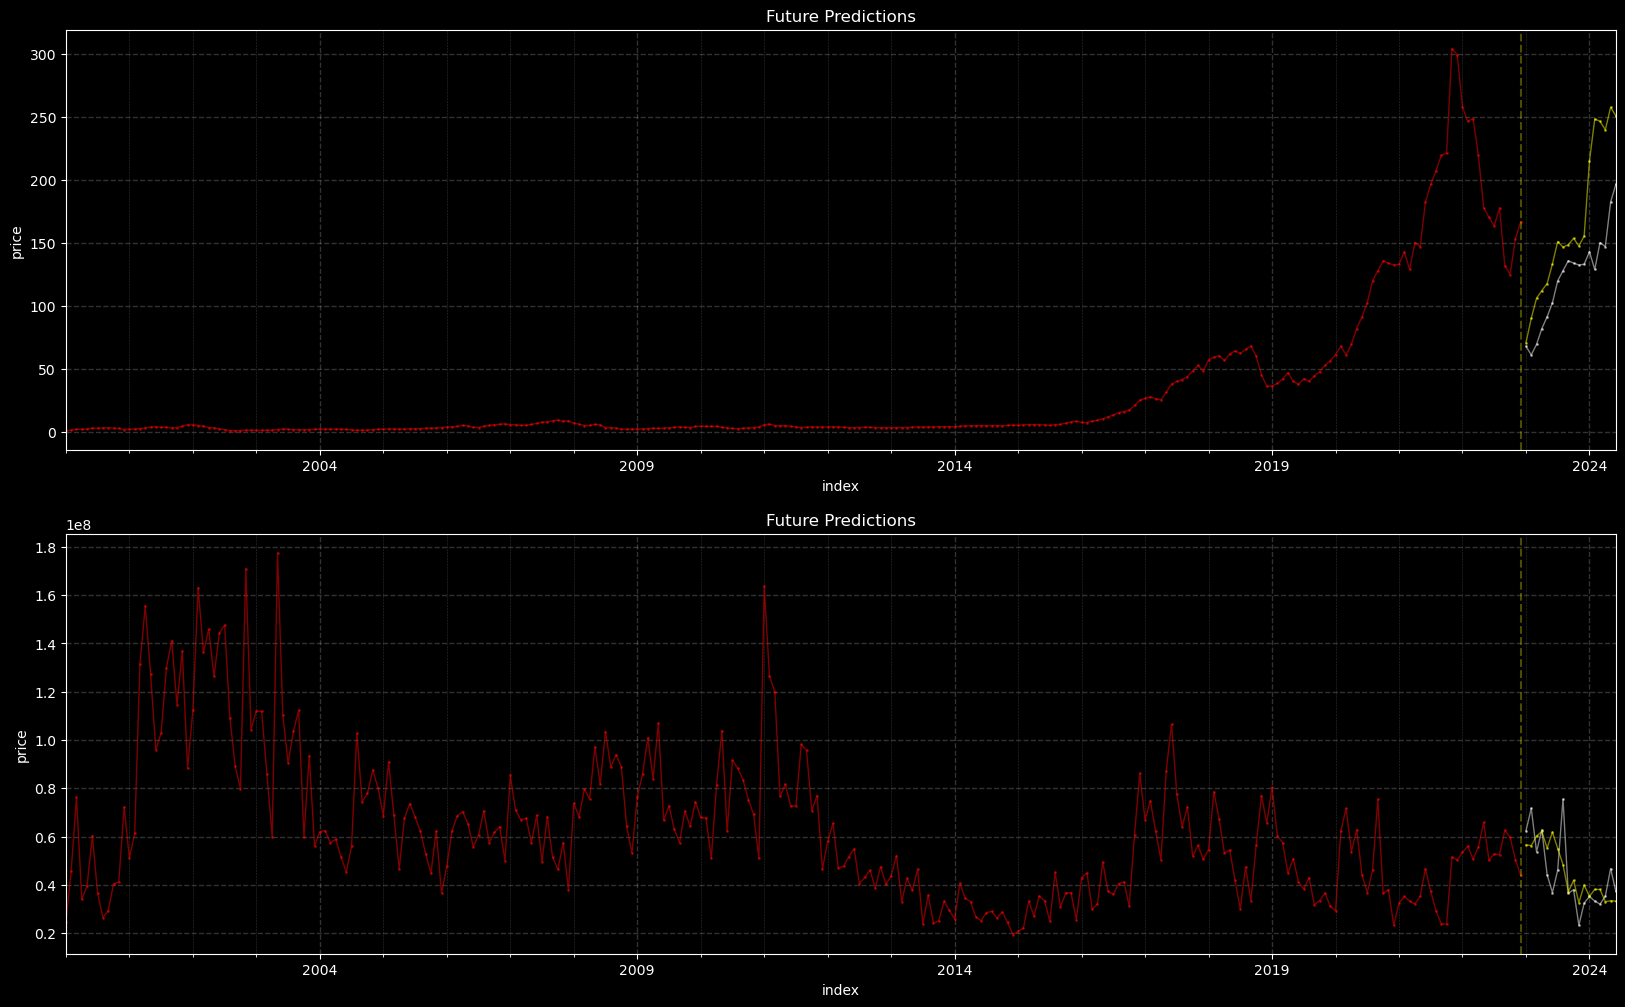

In [103]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["gbr_pred_close"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)




df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_volume"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

In [115]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

short_name = "svm"
svm_seq = SVR() # can't add random_state = 42??
multioutput_svm_seq = MultiOutputRegressor(svm_seq)
multioutput_svm_seq.fit(X_train, y_train)


"""
Run Forecasts
"""
svm_seq_preds = multioutput_svm_seq.predict(forecast_inputs) # X_test

"""
Store Results
"""

forecast_dict = cat_val_in_arr(svm_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but SVR was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.c

In [111]:
"""
KNN
"""
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
short_name = "knn"
knn = KNeighborsRegressor()
multioutput_knn = MultiOutputRegressor(knn) # Look into multiouput regressor. Still get same result without it....

multioutput_knn.fit(X_train,y_train)
knn_seq_preds = multioutput_knn.predict(forecast_inputs)


"""
Store Results
"""

forecast_dict = cat_val_in_arr(knn_seq_preds[0], TARGET)
            
            
# # Save results in data frame
for target_idx, target_name in enumerate(TARGET):
    forecast_df[f"{short_name}_pred_{target_name.lower()}"] = forecast_dict[target_name] #dt_seq_res[0]

/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/home/studio-lab-user/.conda/envs/ml_env_3_7/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.

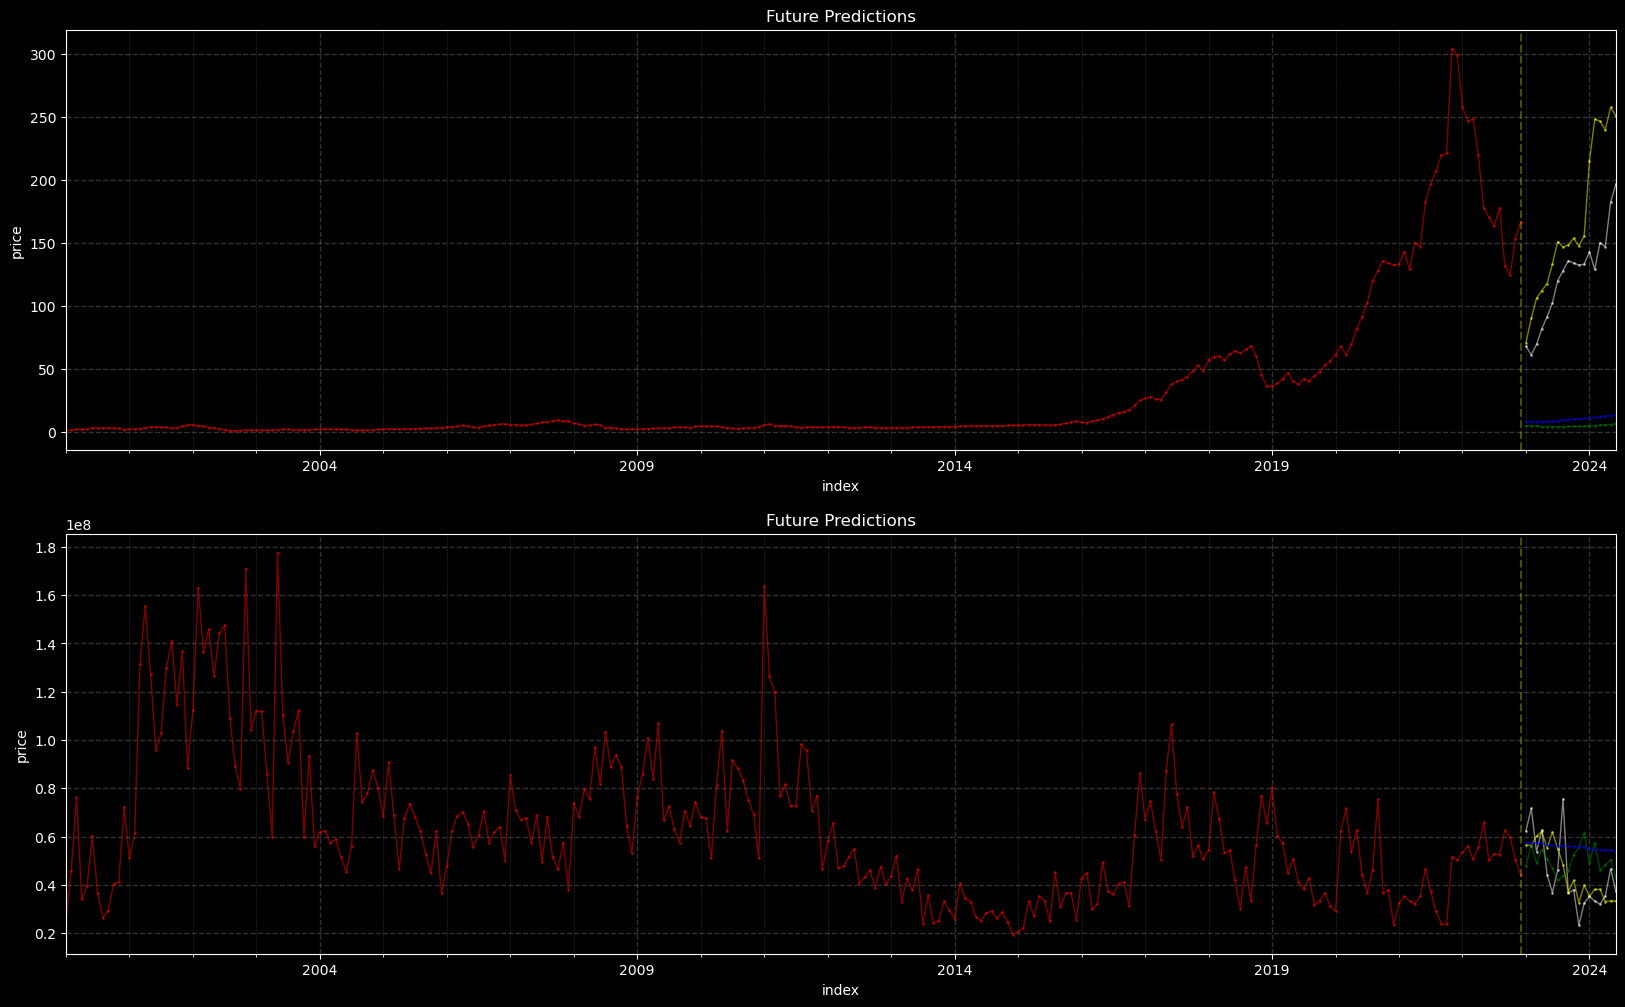

In [116]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, axes = plt.subplots(nrows=2) # fig, axes = plt.subplots(nrows=2, ncols=2)


df["close"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["gbr_pred_close"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

forecast_df["knn_pred_close"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_close"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[0],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)





df["volume"].plot(figsize=(20, 12),
                               color="red",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_volume"].plot(figsize=(20, 12),
                               color="white",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_volume"].plot(figsize=(20, 12),
                               color="yellow",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["knn_pred_volume"].plot(figsize=(20, 12),
                               color="green",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["svm_pred_volume"].plot(figsize=(20, 12),
                               color="blue",
                               ms=1,
                               lw=1,
                               ax=axes[1],
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)

axes[0].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[0].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[0].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)


axes[1].axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
axes[1].grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
axes[1].grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()

## Classic Plotting

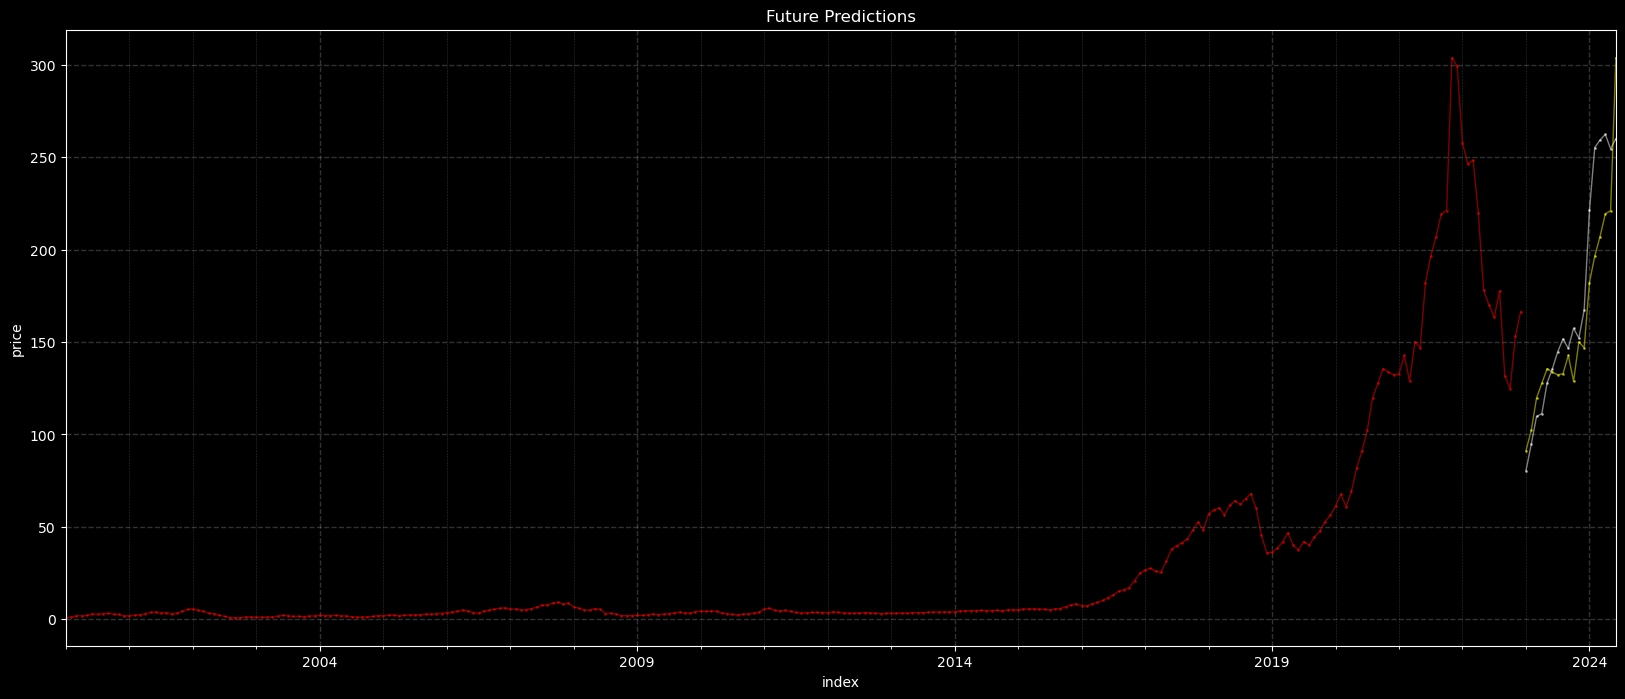

In [15]:
#Plot Values
plt.style.use('dark_background')

signal_to_plot = "close"

fig, ax = plt.subplots()

df[signal_to_plot].plot(figsize=(20, 8),
                               color="red",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["dt_pred_close"].plot(figsize=(20, 8),
                               color="yellow",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
forecast_df["gbr_pred_close"].plot(figsize=(20, 8),
                               color="white",
                               ms=1,
                               lw=1,
                               title='Future Predictions', marker = 'o', ylabel = "price", alpha = 0.5)
#ax.axvline(lagged_df.index.max(), color='yellow', ls='--', alpha = 0.3)
ax.grid(which = "major", color='w', linestyle='--', linewidth=1, alpha = 0.2)
ax.grid(which = "minor", color='w', linestyle='--', linewidth=0.4, alpha = 0.2)
plt.show()